# HW3 - John Pezzuto

### Load Packages, Data, & Functions

In [31]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
import numpy.linalg as lin
plt.style.use("ggplot")
%matplotlib inline

In [18]:
incomes = np.loadtxt('incomes.txt')
sick = pd.read_csv("sick.txt")
inc_sim = np.linspace(0.01, 150000, 200)

In [19]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):## log normal dist w/ truncated
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    log_pdf_vals = (((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - ((np.log(xvals)) - mu)**2 / (2 * sigma**2))) / 
                    prob_notcut)
    return log_pdf_vals 

def data_moments(xvals):  ## mean & standard deviation moments for data
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data


def model_moments(mu, sigma, cutoff):  ## returns mean & std moements for GMM
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.00001, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.00001, cutoff)
    std_model = np.sqrt(var_model)
    return mean_model, std_model


def err_vec(xvals, mu, sigma, cutoff, simple): #use data and model stats to find error
    mean_data, std_data = data_moments(xvals) #mean and std from data
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data #difference
    else:
        err_vec = (moms_model - moms_data) / moms_data #percent deviation between data and model moments
    
    return err_vec


def criterion(params, *args):  ## weighted sum of squared moment errors
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) # plug in weighting matrix
    
    return crit_val

## a) Plot a Histogram

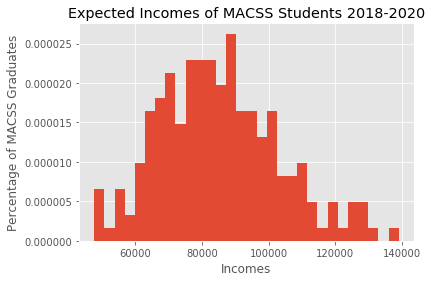

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")

## b) Estimate the parameters of the lognormal distribution by generalized method of moments

In [21]:
mu_init = 11
sig_init = .5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) #identity matrix


gmm_args = (incomes, 150000.0, W_hat) #why that number
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.336910231  sig_GMM1= 0.213027684722


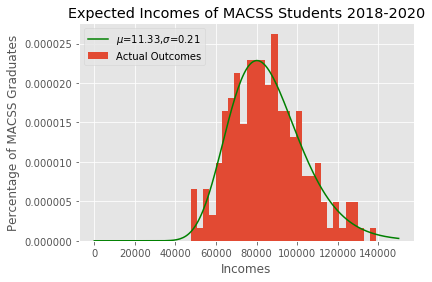

In [24]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = '$\mu$=11.33,$\sigma$=0.21')
plt.legend(loc = 'upper left')

## c) Two-Step GMM Estimation

In [32]:
err1 = err_vec(inc_sim, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / inc_sim.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[  9.38780263e-05  -4.01858424e-04]
 [ -4.01858424e-04   1.72021291e-03]]
[[  28.52632623 -122.11105132]
 [-122.11105132  522.71395676]]


In [39]:
mu_init = 11 #step 2: re-estimate the GMM estimator using the optimal two-step weighting matrix.
sig_init = .5
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (inc_sim, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

# get criterion function values at the estimated GMM parameter values
params_GMM2 = np.array([mu_GMM2, sig_GMM2])
GMM2_Value = criterion(params_GMM2, *gmm_args)[0][0]

# compare model moments and data moments
mean_data, std_data = data_moments(inc_sim)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)

mu_GMM2= 12.4068725656  sig_GMM2= 1.36573239815


26345.782088604767

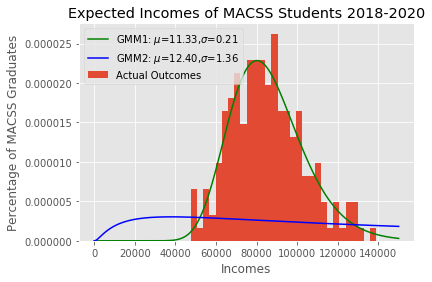

In [44]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = 'GMM1: $\mu$=11.33,$\sigma$=0.21')
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2, sig_GMM2, 150000), color = 'b', label = 'GMM2: $\mu$=12.40,$\sigma$=1.36')
plt.legend(loc = 'upper left')

## d) GMM Estimate With Different Moments

In [45]:
def data_moments3(xvals):
    bpct_1 = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2 = (xvals[(xvals >=75000) & (xvals <= 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3 = xvals[xvals > 100000].shape[0] / xvals.shape[0]
    
    return bpct_1, bpct_2, bpct_3

def model_3moments(mu, sigma, cutoff):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.00001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_3vec(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_3moments(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_3moments(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_3vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val    
